## Advanced Lane Lines Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## Compute the camera calibration matrix and distortion coefficients given a set of chessboard images

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib qt

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# termination criteria
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

fig, axs = plt.subplots(5,4, figsize=(16, 11))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()


# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        corners2 = cv2.cornerSubPix(gray,corners,(11,11),(-1,-1),criteria)
        imgpoints.append(corners)

         # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        axs[idx].axis('off')
        axs[idx].imshow(img)
        
        # Draw and display the corners
        cv2.drawChessboardCorners(img, (8,6), corners, ret)
        #write_name = 'corners_found'+str(idx)+'.jpg'
        #cv2.imwrite(write_name, img)
        cv2.imshow('img', img)
        cv2.waitKey(500)
       
## cv2.destroyAllWindows()

Text(0.5, 1.0, 'Undistorted Image')

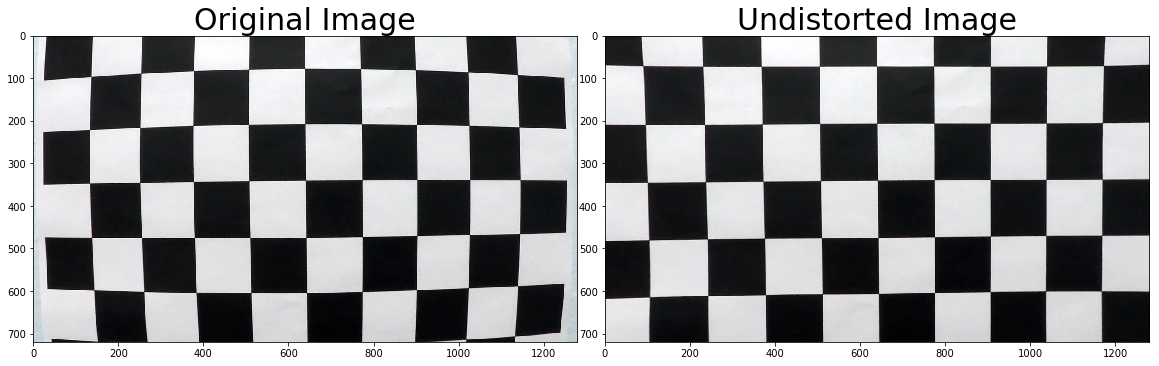

In [2]:
import pickle
%matplotlib inline

# Test undistortion on an image
img = cv2.imread('camera_cal/calibration1.jpg')
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)

dst = cv2.undistort(img, mtx, dist, None, mtx)
#cv2.imwrite('calibration_wide/test_undist.jpg',dst)

# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "camera_cal/calibration.p", "wb" ) )
#dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
f.subplots_adjust(hspace = .2, wspace=.05)
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)


## 1. Apply a distortion correction to raw images

In [3]:
# Load test images.
testImages = list(map(lambda imageFileName: (imageFileName, cv2.imread(imageFileName)), 
                      glob.glob('test_images/*.jpg')))


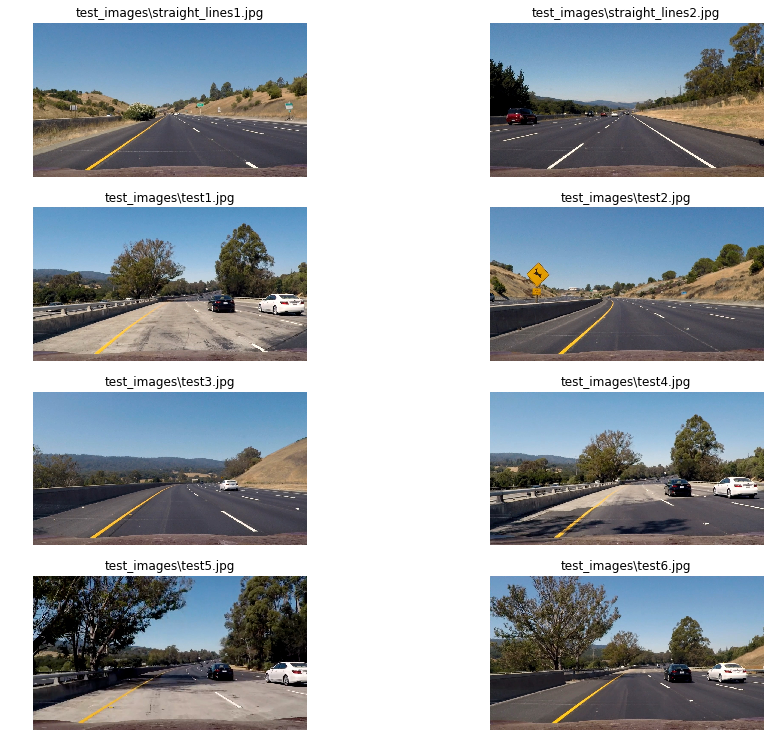

In [4]:
def showImages(images, cols = 4, rows = 5, figsize=(20,15), cmap = None):
    """
    Display `images` on a [`cols`, `rows`] subplot grid.
    """
    imgLength = len(images)
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    indexes = range(cols * rows)
    for ax, index in zip(axes.flat, indexes):
        if index < imgLength:
            imagePathName, image = images[index]
            if cmap == None:
                ax.imshow(image)
            else:
                ax.imshow(image, cmap=cmap)
            ax.set_title(imagePathName)
            ax.axis('off')
        
#showImages(testImages, 2, 4, (15, 15))
showImages(list(map(lambda img: (img[0], cv2.cvtColor(img[1], cv2.COLOR_BGR2RGB)),testImages)), 2, 4, (15, 13))

In [5]:
# undistort image using camera calibration matrix from above
def undistort(img):
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

Text(0.5, 1.0, 'Undistorted Image')

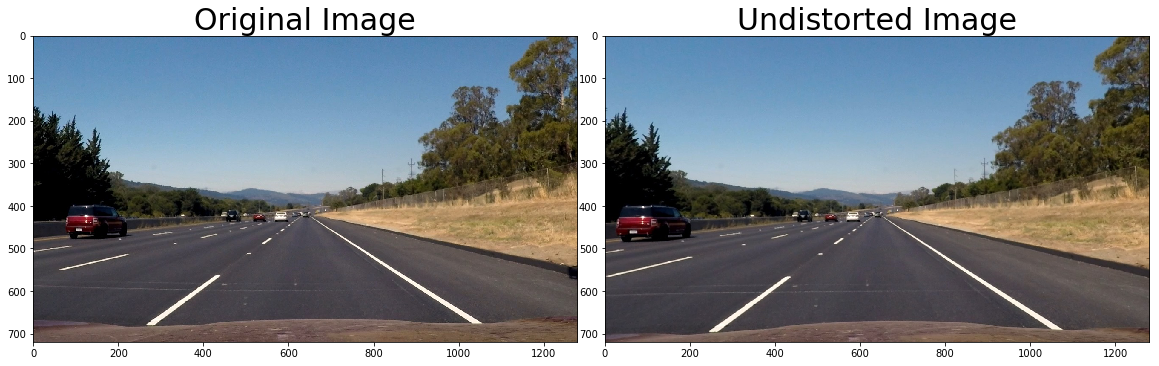

In [6]:
index = 1
image = testImages[index][1]
exampleImg = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
exampleImg_undistort = undistort(exampleImg)

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
f.subplots_adjust(hspace = .2, wspace=.05)
ax1.imshow(exampleImg)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(exampleImg_undistort)
ax2.set_title('Undistorted Image', fontsize=30)


## 2. Use color transforms, gradients, etc., to create a thresholded binary image

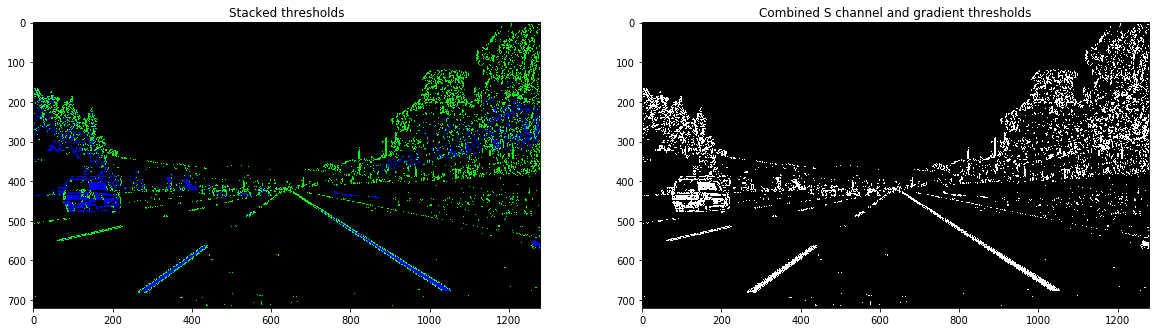

In [7]:
index = 1
img = testImages[index][1]

# Convert to HLS color space and separate the S channel
# Note: img is the undistorted image
hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
s_channel = hls[:,:,2]

# Grayscale image
# NOTE: we already saw that standard grayscaling lost color information for the lane lines
# Explore gradients in other colors spaces / color channels to see what might work better
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

# Sobel x
sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

# Threshold x gradient
thresh_min = 20
thresh_max = 100
sxbinary = np.zeros_like(scaled_sobel)
sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

# Threshold color channel
s_thresh_min = 170
s_thresh_max = 255
s_binary = np.zeros_like(s_channel)
s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1

# Stack each channel to view their individual contributions in green and blue respectively
# This returns a stack of the two binary images, whose components you can see as different colors
color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255

# Combine the two binary thresholds
combined_binary = np.zeros_like(sxbinary)
combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1

# Plotting thresholded images
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_title('Stacked thresholds')
ax1.imshow(color_binary)

ax2.set_title('Combined S channel and gradient thresholds')
ax2.imshow(combined_binary, cmap='gray')

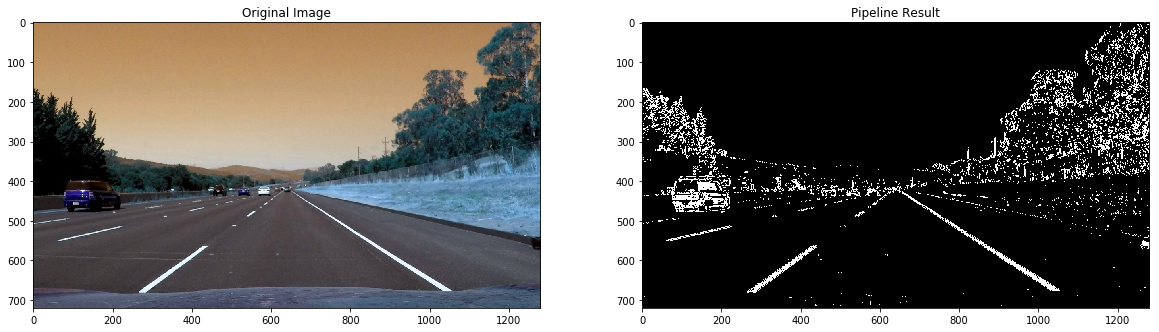

In [8]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

#image = mpimg.imread('bridge_shadow.jpg')

index = 1
image = testImages[index][1]

# Edit this function to create your own pipeline.
def pipeline(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    img = np.copy(img)
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # Sobel x
    #sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    #abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    #scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    #sxbinary = np.zeros_like(scaled_sobel)
    #sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    thresh_min = 20
    thresh_max = 100
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # Stack each channel
    
    s_thresh_min = 170
    s_thresh_max = 255
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1
    
    
    #color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255
    
    # Stack each channel to view their individual contributions in green and blue respectively
    # This returns a stack of the two binary images, whose components you can see as different colors
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255
 
    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    
    return combined_binary
    
result = pipeline(image)

## Plot the result
#f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
#f.tight_layout()

#ax1.imshow(image)
#ax1.set_title('Original Image', fontsize=40)
#ax1.imshow(image)

#ax2.imshow(result)
#ax2.set_title('Pipeline Result', fontsize=40)

#plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
#ax2.imshow(result, cmap='gray')



# Plotting thresholded images
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_title('Original Image')
ax1.imshow(image)

ax2.set_title('Pipeline Result')
ax2.imshow(result, cmap='gray')

In [9]:
def applyAndPack(images, action):
    """
    Images is a colletion of pairs (`title`, image). This function applies `action` to the image part of `images`
    and pack the pair again to form (`title`, `action`(image)).
    """
    return list(map(lambda img: (img[0], action(img[1])), images))

def applyAndShow(images, action, cmap='gray'):
    """
    Applies `action` to the pair collection `images` (`title`, image) show the images and titles and return
    (`title`, `action`(image))
    """
    output = applyAndPack(images, action)
    showImages( output, 2, 4, (20, 20), cmap=cmap)
    return output

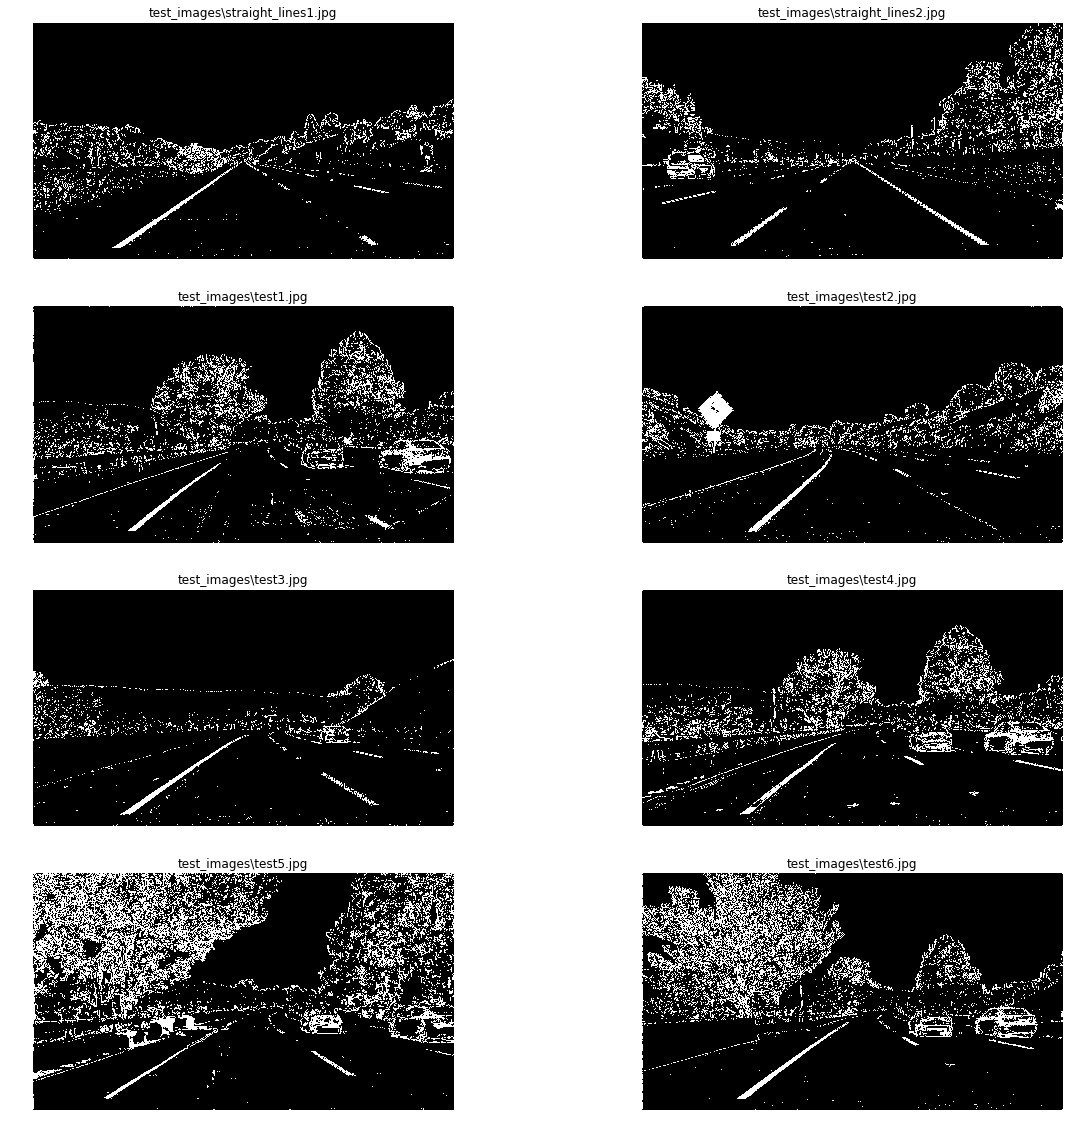

In [10]:
resultCombined = applyAndShow(testImages, pipeline)

## 3. Apply a perspective transform to rectify binary image ("birds-eye view")

In [11]:
def unwarp(img, src, dst):
    #h,w = img.shape[:2]
    img_size = (image.shape[1], image.shape[0])
    # use cv2.getPerspectiveTransform() to get M, the transform matrix, and Minv, the inverse
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    # use cv2.warpPerspective() to warp your image to a top-down view
    #warped = cv2.warpPerspective(img, M, (w,h), flags=cv2.INTER_LINEAR)
    warped = cv2.warpPerspective(image, M, img_size)
    return warped, M, Minv
    #return warped

Text(0.5, 1.0, 'Warped Image')

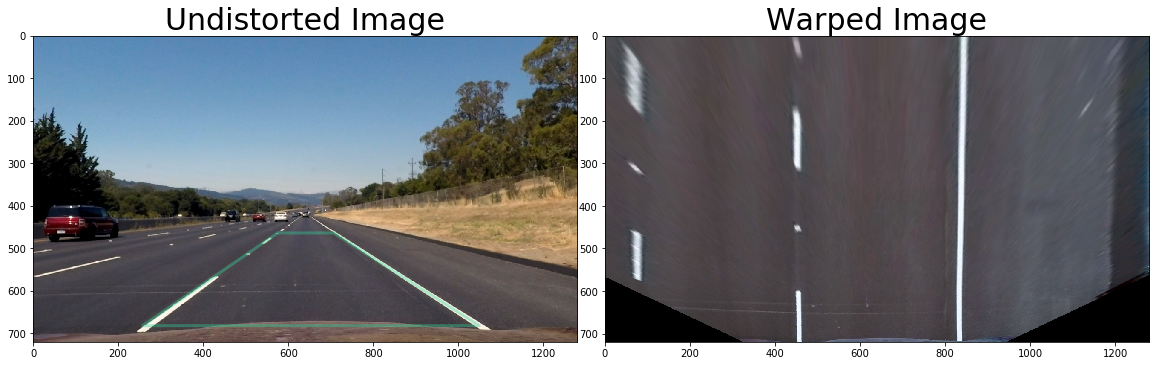

In [12]:

h,w = exampleImg_undistort.shape[:2]

# define source and destination points for transform
src = np.float32([(575,464),
                  (707,464), 
                  (258,682), 
                  (1049,682)])
dst1 = np.float32([(450,0),
                  (w-450,0),
                  (450,h),
                  (w-450,h)])

exampleImg_unwarp, M, Minv = unwarp(exampleImg_undistort, src, dst1)
#exampleImg_unwarp= unwarp(exampleImg_undistort, src, dst1)

# Visualize unwarp
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
f.subplots_adjust(hspace = .2, wspace=.05)
ax1.imshow(exampleImg_undistort)
x = [src[0][0],src[2][0],src[3][0],src[1][0],src[0][0]]
y = [src[0][1],src[2][1],src[3][1],src[1][1],src[0][1]]
ax1.plot(x, y, color='#33cc99', alpha=0.4, linewidth=3, solid_capstyle='round', zorder=2)
ax1.set_ylim([h,0])
ax1.set_xlim([0,w])
ax1.set_title('Undistorted Image', fontsize=30)
ax2.imshow(exampleImg_unwarp)
ax2.set_title('Warped Image', fontsize=30)

In [13]:
transMatrix = pickle.load( open('./pickled_data/perspective_transform.p', 'rb' ) )
M, Minv = map(transMatrix.get, ('M', 'Minv'))

def adjustPerspective(image, M=M):
    """
    Adjust the `image` using the transformation matrix `M`.
    """
    img_size = (image.shape[1], image.shape[0])
           
    #M = cv2.getPerspectiveTransform(src, dst)

    warped = cv2.warpPerspective(image, M, img_size)
    return warped

combineAndTransform = lambda img: adjustPerspective(pipeline(img))

#combineAndTransform = lambda img: unwarp(pipeline(img),src,dst1)

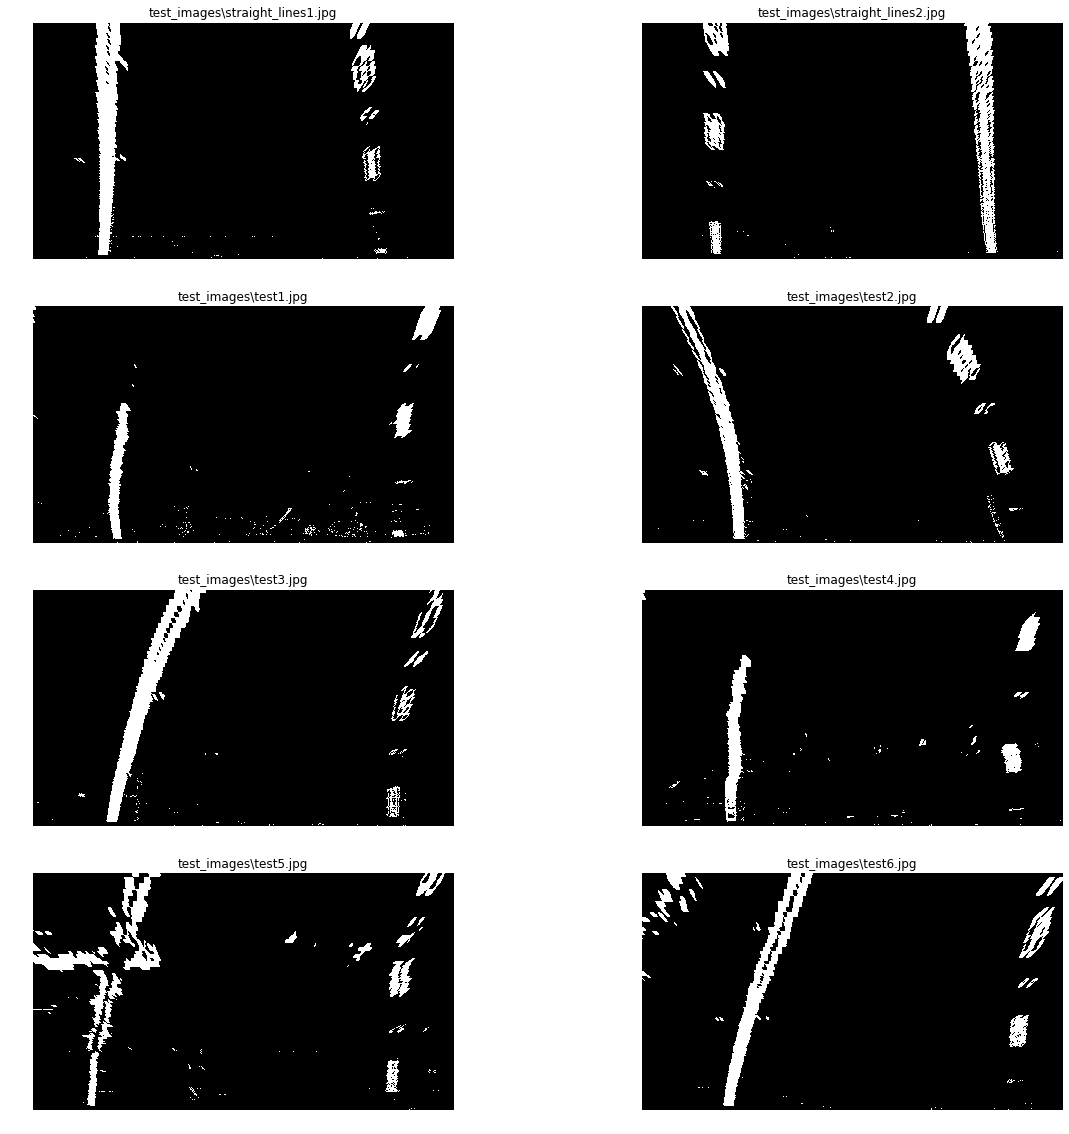

In [14]:
resultPerspective = applyAndShow(testImages, combineAndTransform, cmap='gray')

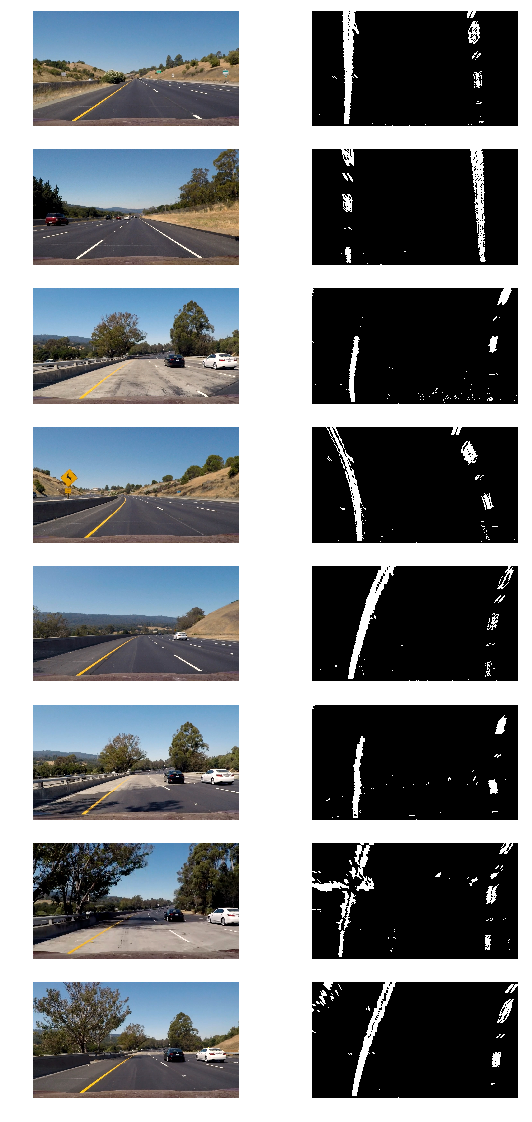

In [15]:
#binary_warped = exampleImg_unwarp

# Make a list of example images
images = glob.glob('test_images/*.jpg')
                                          
# Set up plot
fig, axs = plt.subplots(len(images),2, figsize=(10, 20))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()

i = 0
for image in images:
    img = cv2.imread(image)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    binary_warped = adjustPerspective(pipeline(img), M=M)
    #binary_warped = adjustPerspective(img, M=M)
    axs[i].imshow(img)
    axs[i].axis('off')
    i += 1
    axs[i].imshow(binary_warped, cmap='gray')
    axs[i].axis('off')
    i += 1

## 4. Detect lane pixels and fit to find the lane boundary

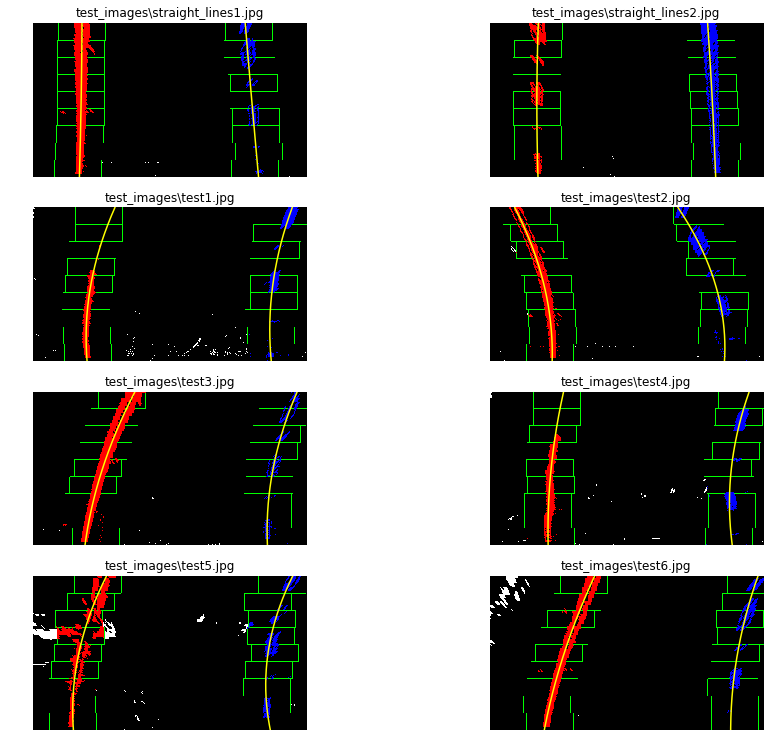

In [16]:
# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

# Load our image
#binary_warped = mpimg.imread('warped_example.jpg')


def findlines(image, nwindows=9, margin=110, minpix=50):
    """
    Find the polynomial representation of the lines in the `image` using:
    - `nwindows` as the number of windows.
    - `margin` as the windows margin.
    - `minpix` as minimum number of pixes found to recenter the window.
    - `ym_per_pix` meters per pixel on Y.
    - `xm_per_pix` meters per pixels on X.
    
    Returns (left_fit, right_fit, left_lane_inds, right_lane_inds, out_img, nonzerox, nonzeroy)
    """    
    # Make a binary and transform image
    binary_warped = combineAndTransform(image)
    #binary_warped = adjustPerspective(pipeline(image),M=M)
    #binary_warped = combineAndTransform(image)
    
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    
    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
    
    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Fit a second order polynomial to each
    left_fit_m = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_m = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    
    return (left_fit, right_fit, left_fit_m, right_fit_m, left_lane_inds, right_lane_inds, out_img, nonzerox, nonzeroy)
    
def visualizeLanes(image, ax):
    """
    Visualize the windows and fitted lines for `image`.
    Returns (`left_fit` and `right_fit`)
    """
    left_fit, right_fit, left_fit_m, right_fit_m, left_lane_inds, right_lane_inds, out_img, nonzerox, nonzeroy = findlines(image)
    ##find_lane_pixels, findlines
    # Visualization
    ploty = np.linspace(0, image.shape[0]-1, image.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    ax.imshow(out_img)
    ax.plot(left_fitx, ploty, color='yellow')
    ax.plot(right_fitx, ploty, color='yellow')
    return ( left_fit, right_fit, left_fit_m, right_fit_m )    
    
    
    
def fit_polynomial(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    ### TO-DO: Fit a second order polynomial to each using `np.polyfit` ###
    #left_fit = None
    #right_fit = None
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')

    return out_img

def showLaneOnImages(images, cols = 2, rows = 4, figsize=(15,13)):
    """
    Display `images` on a [`cols`, `rows`] subplot grid.
    Returns a collection with the image paths and the left and right polynomials.
    """
    imgLength = len(images)
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    indexes = range(cols * rows)
    imageAndFit = []
    for ax, index in zip(axes.flat, indexes):
        if index < imgLength:
            imagePathName, image = images[index]
            left_fit, right_fit, left_fit_m, right_fit_m = visualizeLanes(image, ax)
            ax.set_title(imagePathName)
            ax.axis('off')
            imageAndFit.append( ( imagePathName, left_fit, right_fit, left_fit_m, right_fit_m ) )
    return imageAndFit



imagesPoly = showLaneOnImages(testImages)
#plt.imshow(imagesPoly)


## 5. Determine the curvature of the lane and vehicle position with respect to center

In [17]:
def calculateCurvature(yRange, left_fit_cr):
    """
    Returns the curvature of the polynomial `fit` on the y range `yRange`.
    """
    
    return ((1 + (2*left_fit_cr[0]*yRange*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])

for imagePoly in imagesPoly:
    imagePath, left_fit, right_fit, left_fit_m, right_fit_m = imagePoly
    yRange = 719
    leftCurvature = calculateCurvature(yRange, left_fit_m) / 1000
    rightCurvature = calculateCurvature(yRange, right_fit_m) / 1000
    print('Image : {}, Left : {:.2f} km, Right : {:.2f} km'.format(imagePath, leftCurvature, rightCurvature))

Image : test_images\straight_lines1.jpg, Left : 9.95 km, Right : 28.69 km
Image : test_images\straight_lines2.jpg, Left : 3.59 km, Right : 7.27 km
Image : test_images\test1.jpg, Left : 0.45 km, Right : 0.51 km
Image : test_images\test2.jpg, Left : 0.44 km, Right : 0.32 km
Image : test_images\test3.jpg, Left : 0.61 km, Right : 0.49 km
Image : test_images\test4.jpg, Left : 0.96 km, Right : 0.48 km
Image : test_images\test5.jpg, Left : 0.41 km, Right : 0.34 km
Image : test_images\test6.jpg, Left : 0.87 km, Right : 0.68 km


## 6. Warp the detected lane boundaries back onto the original image

In [18]:
def draw_lane(original_img, binary_img, l_fit, r_fit, Minv):
    new_img = np.copy(original_img)
    if l_fit is None or r_fit is None:
        return original_img
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_img).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    h,w = binary_img.shape
    ploty = np.linspace(0, h-1, num=h)# to cover same y-range as image
    left_fitx = l_fit[0]*ploty**2 + l_fit[1]*ploty + l_fit[2]
    right_fitx = r_fit[0]*ploty**2 + r_fit[1]*ploty + r_fit[2]

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    cv2.polylines(color_warp, np.int32([pts_left]), isClosed=False, color=(255,0,255), thickness=15)
    cv2.polylines(color_warp, np.int32([pts_right]), isClosed=False, color=(0,255,255), thickness=15)

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (w, h)) 
    # Combine the result with the original image
    result = cv2.addWeighted(new_img, 1, newwarp, 0.5, 0)
    return result

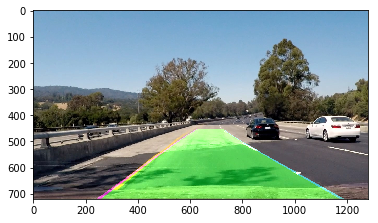

In [19]:
#i = 0
#for image in images:
import sys
sys.setrecursionlimit(1500)
exampleImg = cv2.imread('test_images/test4.jpg')
exampleImg = cv2.cvtColor(exampleImg, cv2.COLOR_BGR2RGB)
exampleImg_bin = pipeline(exampleImg) 
    
exampleImg_out1 = draw_lane(exampleImg, exampleImg_bin, left_fit, right_fit, Minv)
plt.imshow(exampleImg_out1)


#print('...')

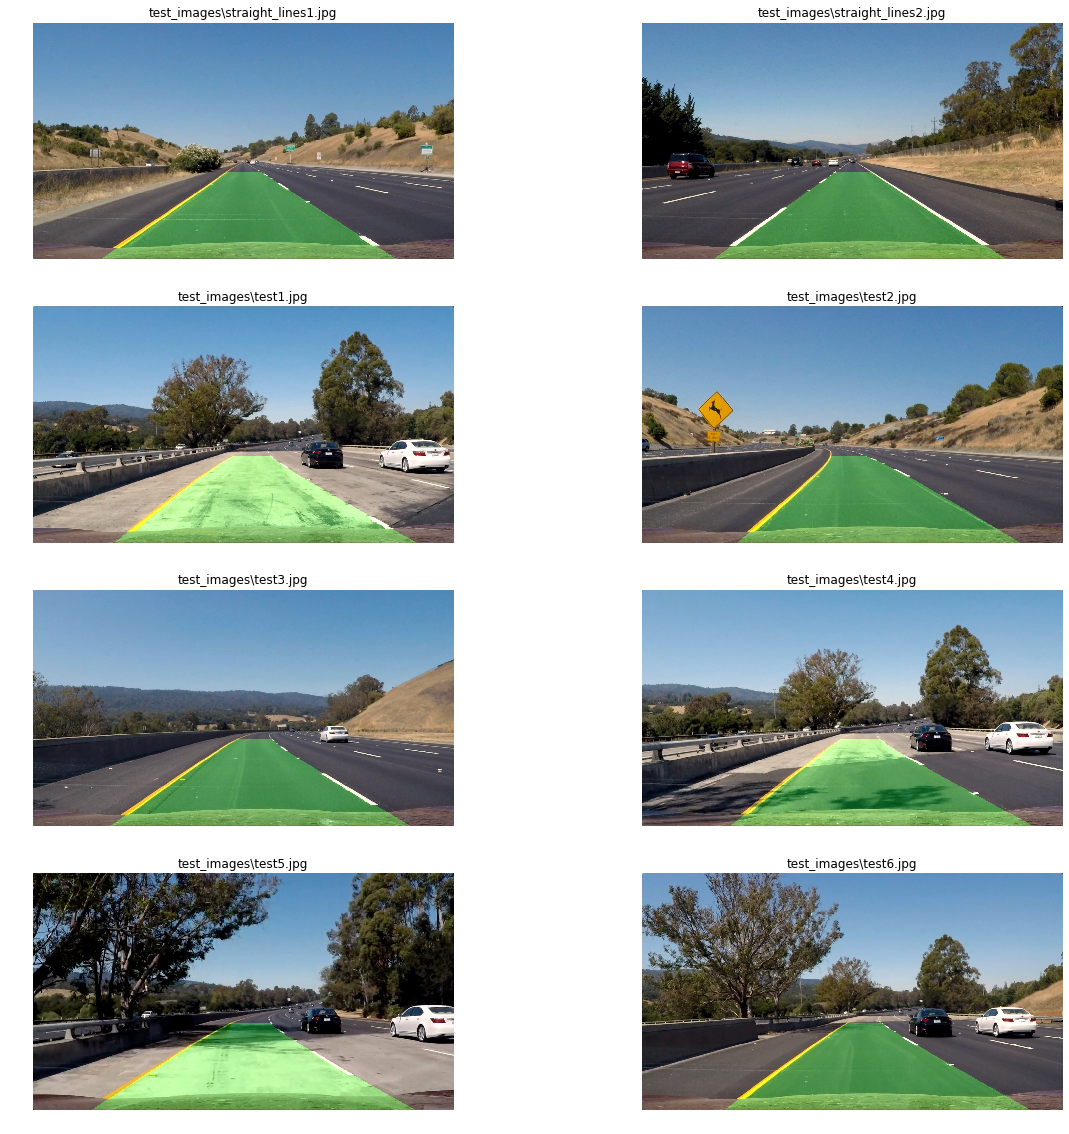

In [20]:


def drawLine(img, left_fit, right_fit):
    """
    Draw the lane lines on the image `img` using the poly `left_fit` and `right_fit`.
    """
    yMax = img.shape[0]
    ploty = np.linspace(0, yMax - 1, yMax)
    color_warp = np.zeros_like(img).astype(np.uint8)
    
    # Calculate points.
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 
    return cv2.addWeighted(img, 1, newwarp, 0.3, 0)

def drawLaneOnImage(img):
    """
    Find and draw the lane lines on the image `img`.
    """
    left_fit, right_fit, left_fit_m, right_fit_m, _, _, _, _, _ = findlines(img)
    output = drawLine(img, left_fit, right_fit)
    return cv2.cvtColor( output, cv2.COLOR_BGR2RGB )

resultLines = applyAndShow(testImages, drawLaneOnImage)

## 7. Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position

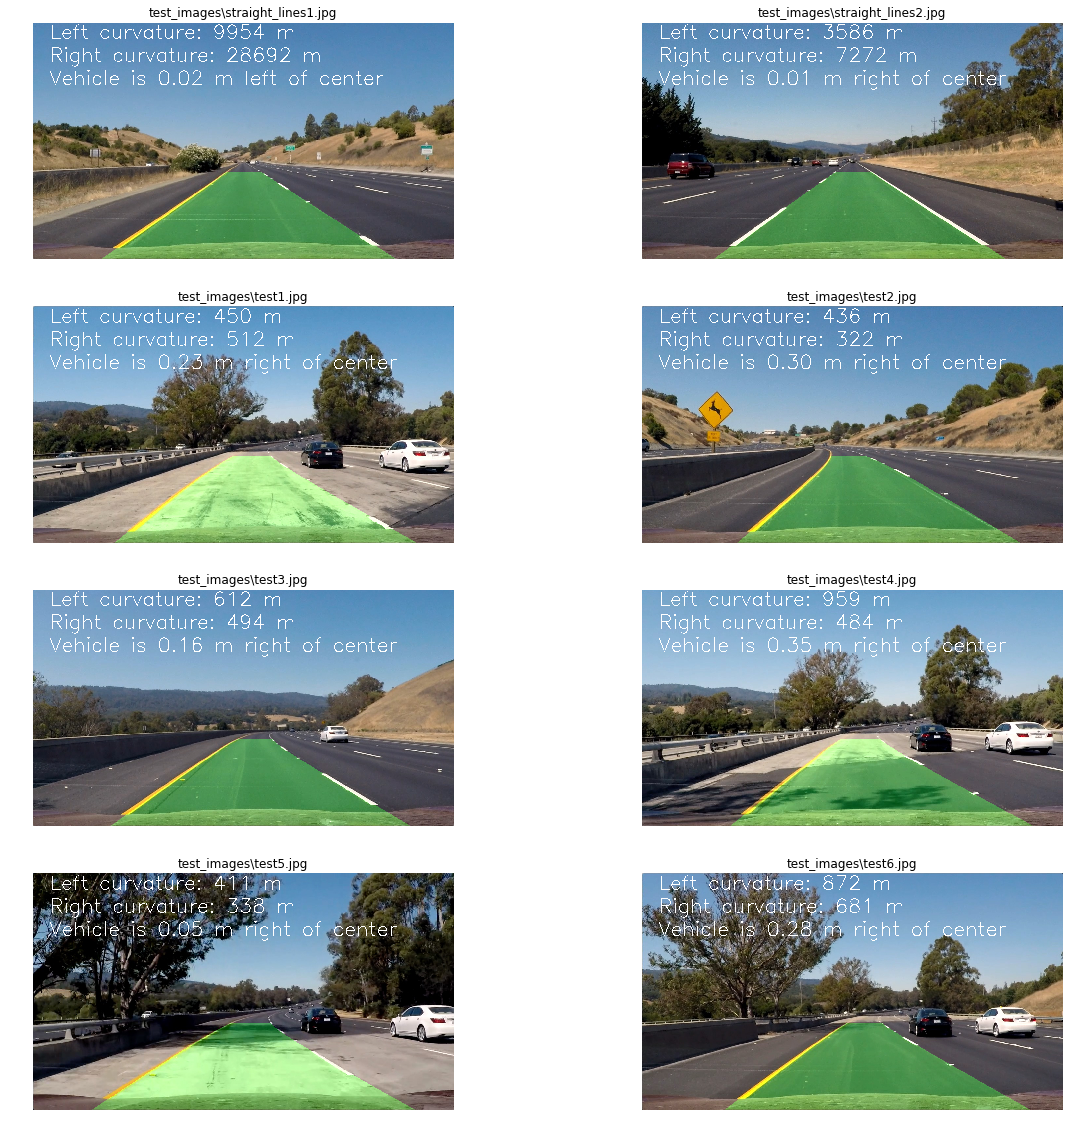

In [21]:
def pipeline2(img, fontScale=2):
    """
    Find and draw the lane lines on the image `img`.
    """
    left_fit, right_fit, left_fit_m, right_fit_m, _, _, _, _, _ = findlines(img)
    output = drawLine(img, left_fit, right_fit)
    
    # Calculate curvature
    leftCurvature = calculateCurvature(yRange, left_fit_m) 
    rightCurvature = calculateCurvature(yRange, right_fit_m)
    
    # Calculate vehicle center
    xMax = img.shape[1]*xm_per_pix
    yMax = img.shape[0]*ym_per_pix
    vehicleCenter = xMax / 2
    lineLeft = left_fit_m[0]*yMax**2 + left_fit_m[1]*yMax + left_fit_m[2]
    lineRight = right_fit_m[0]*yMax**2 + right_fit_m[1]*yMax + right_fit_m[2]
    lineMiddle = lineLeft + (lineRight - lineLeft)/2
    diffFromVehicle = lineMiddle - vehicleCenter
    if diffFromVehicle > 0:
        message = '{:.2f} m right'.format(diffFromVehicle)
    else:
        message = '{:.2f} m left'.format(-diffFromVehicle)
    
    # Draw info
    font = cv2.FONT_HERSHEY_SIMPLEX
    fontColor = (255, 255, 255)
    cv2.putText(output, 'Left curvature: {:.0f} m'.format(leftCurvature), (50, 50), font, fontScale, fontColor, 2)
    cv2.putText(output, 'Right curvature: {:.0f} m'.format(rightCurvature), (50, 120), font, fontScale, fontColor, 2)
    cv2.putText(output, 'Vehicle is {} of center'.format(message), (50, 190), font, fontScale, fontColor, 2)
    return output

#import sys
#sys.setrecursionlimit(10**6)
resultDisplay = applyAndShow(testImages, lambda img: cv2.cvtColor(pipeline2(img), cv2.COLOR_BGR2RGB ))

## 8. Video pipeline

In [22]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

class Lane():
    def __init__(self):
        self.left_fit = None
        self.right_fit = None
        self.left_fit_m = None
        self.right_fit_m = None
        self.leftCurvature = None
        self.rightCurvature = None

def calculateLanes(img):
    """
    Calculates the lane on image `img`.
    """
    left_fit, right_fit, left_fit_m, right_fit_m, _, _, _, _, _ = findlines(img)
    # Calculate curvature
    leftCurvature = calculateCurvature(yRange, left_fit_m) 
    rightCurvature = calculateCurvature(yRange, right_fit_m)
    
    # Calculate vehicle center
    xMax = img.shape[1]*xm_per_pix
    yMax = img.shape[0]*ym_per_pix
    vehicleCenter = xMax / 2
    lineLeft = left_fit_m[0]*yMax**2 + left_fit_m[1]*yMax + left_fit_m[2]
    lineRight = right_fit_m[0]*yMax**2 + right_fit_m[1]*yMax + right_fit_m[2]
    lineMiddle = lineLeft + (lineRight - lineLeft)/2
    diffFromVehicle = lineMiddle - vehicleCenter
    
    return (left_fit, right_fit, left_fit_m, right_fit_m, leftCurvature, rightCurvature, diffFromVehicle)

def displayLanes(img, left_fit, right_fit, left_fit_m, right_fit_m, leftCurvature, rightCurvature, diffFromVehicle):
    """
    Display the lanes information on the image.
    """
    output = drawLine(img, left_fit, right_fit)
    
    if diffFromVehicle > 0:
        message = '{:.2f} m right'.format(diffFromVehicle)
    else:
        message = '{:.2f} m left'.format(-diffFromVehicle)
    
    # Draw info
    font = cv2.FONT_HERSHEY_SIMPLEX
    fontColor = (255, 255, 255)
    cv2.putText(output, 'Left curvature: {:.0f} m'.format(leftCurvature), (50, 50), font, 1, fontColor, 2)
    cv2.putText(output, 'Right curvature: {:.0f} m'.format(rightCurvature), (50, 120), font, 1, fontColor, 2)
    cv2.putText(output, 'Vehicle is {} of center'.format(message), (50, 190), font, 1, fontColor, 2)
    return output
    
def videoPipeline(inputVideo, outputVideo):
    """
    Process the `inputVideo` frame by frame to find the lane lines, draw curvarute and vehicle position information and
    generate `outputVideo`
    """
    myclip = VideoFileClip(inputVideo)
    
    ##video_clip.reader.close()
    ##video_clip.audio.reader.close_proc()
    
    leftLane = Lane()
    rightLane = Lane()
    
    def processImage(img):
        left_fit, right_fit, left_fit_m, right_fit_m, leftCurvature, rightCurvature, diffFromVehicle = calculateLanes(img)
        if leftCurvature > 10000:
            left_fit = leftLane.left_fit
            left_fit_m = leftLane.left_fit_m
            leftCurvature = leftLane.leftCurvature
        else:
            leftLane.left_fit = left_fit
            leftLane.left_fit_m = left_fit_m
            leftLane.leftCurvature = leftCurvature
        
        if rightCurvature > 10000:
            right_fit = rightLane.right_fit
            right_fit_m = rightLane.right_fit_m
            rightCurvature = rightLane.rightCurvature
        else:
            rightLane.right_fit = right_fit
            rightLane.right_fit_m = right_fit_m
            rightLane.rightCurvature = rightCurvature
            
        return displayLanes(img, left_fit, right_fit, left_fit_m, right_fit_m, leftCurvature, rightCurvature, diffFromVehicle)

    clip = myclip.fl_image(processImage)
    clip.write_videofile(outputVideo, audio=False)

outputVideo = 'video_output/project_video.mp4'    
    
# Project video
videoPipeline('project_video.mp4', 'video_output/project_video.mp4')

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(outputVideo))

Moviepy - Building video video_output/project_video.mp4.
Moviepy - Writing video video_output/project_video.mp4



Moviepy - Done !
Moviepy - video ready video_output/project_video.mp4
